In [79]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from mlflow.tracking import MlflowClient

from seisnet.utils import get_repo_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
mlflow.set_tracking_uri(f"{get_repo_dir()}/mlruns") # Define the root mlruns directory
client = MlflowClient()
exp = client.get_experiment_by_name("Phasenet-Pytorch-Random-Waveform-Experiment")#Sparse #Random
exp_id = exp.experiment_id

In [114]:
def create_metrics_dataframe(df_runs:pd.DataFrame, select_uuids:list, client:MlflowClient,
                              num_cls:str="1", mtype:str="sparse")->pd.DataFrame:
    """
    Extract key columns from a model run and generate a portable dataframe
    """
    # Extract all the runs with only p-wave predictions and filter by model uuid
    df_runs = df_runs[df_runs["params.num_classes"]==num_cls].reset_index(drop=True)
    df_runs = df_runs[df_runs["params.model_uuid"].isin(select_uuids)].reset_index(drop=True)


    # Extract metrics. Eval metrics will also be extracted here
    best_epochs = df_runs["metrics.best_epoch"].to_numpy().astype(int)
    if mtype=="sparse":
        sep_dist = df_runs["params.sep_dist_meters"].to_numpy().astype(int)
    data_size = df_runs["params.data_size"].to_numpy().astype(int)
    val_loss = []
    run_ids = df_runs["run_id"]
    for i,run_id in enumerate(run_ids):
        hist = client.get_metric_history(run_id, "val_loss")
        val_loss.append(hist[best_epochs[i]].value)
    hawaii_loss = df_runs["params.hawaii_test_loss"].to_numpy().astype(float)
    ylwstn_loss = df_runs["params.yellowstone_test_loss"].to_numpy().astype(float)
    hawaii_recall = df_runs["params.hawaii_recall"].to_numpy().astype(float)
    ylwstn_recall = df_runs["params.yellowstone_recall"].to_numpy().astype(float)
    hawaii_f1 = df_runs["params.hawaii_f1"].to_numpy().astype(float)
    ylwstn_f1 = df_runs["params.yellowstone_f1"].to_numpy().astype(float)
    all_test_loss = df_runs["params.all_test_loss"].to_numpy().astype(float)


    # Create a dataframe
    if mtype=="sparse":
        df = pd.DataFrame({"run_id":run_ids,"dist_m":sep_dist,"data size":data_size,
                           "best_epoch":best_epochs,"val_loss":val_loss,"all_loss":all_test_loss,
                           "haw_loss":hawaii_loss,"ylw_loss":ylwstn_loss,
                           "haw_rcl":hawaii_recall,"ylw_rcl":ylwstn_recall,
                           "haw_f1":hawaii_f1,"ylw_f1":ylwstn_f1,})
        mean_dtsz = df.groupby("dist_m")["data size"].mean().astype(int).to_dict()
        df["data size"] = df["dist_m"].map(mean_dtsz)
        df = df.sort_values(by="dist_m").reset_index(drop=True)
    else:
        df = pd.DataFrame({"run_id":run_ids,"data size":data_size,"val_loss":val_loss,
                           "best_epoch":best_epochs,"all_loss":all_test_loss,
                           "haw_loss":hawaii_loss,"ylw_loss":ylwstn_loss,
                           "haw_rcl":hawaii_recall,"ylw_rcl":ylwstn_recall,
                           "haw_f1":hawaii_f1,"ylw_f1":ylwstn_f1,})
        df = df.sort_values(by="data size").reset_index(drop=True)

    return df
        

In [115]:
runs = mlflow.search_runs(experiment_ids=[exp_id]) # Returns a dataframe

rnd_exp1_uuids = ["74beb110","0e2ba3e4","bc63a05c","9f913164","89df7254",
                "24347cac","41b9ebb4","35eae2de","82d9f461"] # exp 1
rnd_exp2_uuids = ["fc3e3920","40759172","5ff016d3","55d9d7e0","ac78132f",
                "71237bb3","0878d1ab","b2dda203","61b066f4"] # exp 2
rnd_exp3_uuids = ["3d56bd2d","cc2f400d","e65ce341","16950700","9fd68e06",
                "6056534c","574d30d7","6a6850f6","4998fc8d"] # exp 3

rnd_all_uuids = ["8c69c464","f8b6fc3a","c6d4d288","79cb833e","1a26b974","42e9afab",
                 "d0da20ec","486eabf6","e6abe84b","d6a3a1c7","1bde61cc","25da2d9d",
                 "6f81c36c","1d43520b","f328009b","9bb9d447","c1f19962","082e9f5a",
                 "b68dc10a","6c61c433","28da5211","c6682d15","5b41d5a6","41842cba",
                 "b8c724b3","9eec2245","f1408192","3c90e5b9","0110818c","3b72ecff",
                 "4da32722","fd03c220","280db935","f3429f70","5cefe561","372c313b",
                 "7ad7d288","86ae722b","fa3338b2","21dbfb7b","b1939e69","151e9e24",
                 "3c79a11b","ebf5051a","748ca054","62a272eb","2297cd26","2f32e6dd",
                 "86dc813a","39c1b808","16f496fd","69e0758e","8160a4e8","a1936513",
                 "a1e83c54","ce555b66","30eb7c99","393e133d","c11baca9","c4769f2d",
                 "fc2682eb","3123b4c2","a99a1bd0","d1e5106d","142915f1","5b471ee9",
                 "7e16c500","09fab0b7","825c1cc0","85ba1367","2d4cbcf1","30040981",
                 "a27d5e9f","f5876c9a","bc52fd3e","3b797e2c","d883ce10","fbb5caa3",
                 "fc98d1ac","10907efd","8dcc32b3","ae558cdd","a239dbde","83b2efae",
                 "eeeb36a9","df08b653","36e01cec","3d3d4115","34b097f4","75095f52",
                 "24c08233","4998fc8d","6a6850f6","574d30d7","6056534c","9fd68e06",
                 "16950700","e65ce341","cc2f400d","3d56bd2d","fc3e3920","40759172",
                 "5ff016d3","55d9d7e0","ac78132f","71237bb3","0878d1ab","b2dda203",
                 "61b066f4","74beb110","0e2ba3e4","bc63a05c","9f913164","89df7254",
                 "24347cac","41b9ebb4","35eae2de","82d9f461"]

# "74beb110","0e2ba3e4","bc63a05c","9f913164","89df7254",
#                  "24347cac","41b9ebb4","35eae2de","82d9f461","fc3e3920",
#                  "40759172","5ff016d3","55d9d7e0","ac78132f","71237bb3",
#                  "0878d1ab","b2dda203","61b066f4","3d56bd2d","cc2f400d",
#                  "e65ce341","16950700","9fd68e06","6056534c","574d30d7",
#                  "6a6850f6","4998fc8d"


df_rnd_exp1 = create_metrics_dataframe(runs,rnd_exp1_uuids,client,mtype="random")
df_rnd_exp2 = create_metrics_dataframe(runs,rnd_exp2_uuids,client,mtype="random")
df_rnd_exp3 = create_metrics_dataframe(runs,rnd_exp3_uuids,client,mtype="random")
df_rnd_all = create_metrics_dataframe(runs,rnd_all_uuids,client,mtype="random")


### Create the plot

Text(0.5, 0, 'Dataset size')

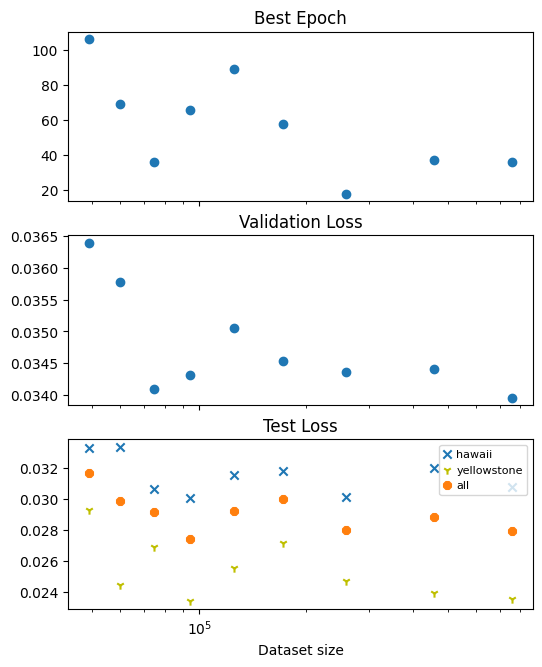

In [61]:
fig,axs = plt.subplots(3,1, figsize=(6,7.5),sharex=True)

df1 = df_rnd_exp2

axs[0].scatter(df1["data size"],df1["best_epoch"])
axs[0].set_title("Best Epoch")
axs[1].scatter(df1["data size"],df1["val_loss"])
axs[1].set_title("Validation Loss")
axs[2].scatter(df1["data size"],df1["haw_loss"],marker="x",label="hawaii")
axs[2].scatter(df1["data size"],df1["ylw_loss"],marker="1",label="yellowstone",c="y")
axs[2].scatter(df1["data size"],df1["all_loss"],marker="8",label="all")
axs[2].set_title("Test Loss")
axs[2].legend(loc="upper right",handlelength=0.63,handletextpad=0.5,fontsize=8)
axs[0].set_xscale("log")#,axs[1].set_yscale("log")
axs[2].set_xlabel("Dataset size")
# random_waveforms_test_metrics
# plt.savefig(f"{get_repo_dir()}/figures/sparse_waveforms_test_metrics.png",
#                 dpi=200,edgecolor="none",bbox_inches="tight")

In [116]:
exp2 = client.get_experiment_by_name("Phasenet-Pytorch-Sparse-Waveform-Experiment")
exp2_id = exp2.experiment_id

e2runs = mlflow.search_runs(experiment_ids=[exp2_id]) # Returns a dataframe

spr_exp1_uuids = ["c885f74f","300b2f61","4c62f344","867b015d","92f4e98c",
                "cc345f33","95a08fc0","b308e37a","6c317bc9"] # exp 1
spr_exp2_uuids = ["95762bd9","943ae619","93dc5689","691d7ea9","1f665244",
                "f0605033","daa82453","0f54124f","5ac3c31a"] # exp 2
spr_exp3_uuids = ["2d2db52f","7fe7beaa","e44148f8","a8349da4","2367277d",
                "699bed83","0752911a","8d94e2e9","0304bee6"] # exp 3 #
spr_all_uuids = ["c885f74f","300b2f61","4c62f344","867b015d","92f4e98c",
                "cc345f33","95a08fc0","b308e37a","6c317bc9","95762bd9",
                "943ae619","93dc5689","691d7ea9","1f665244","f0605033",
                "daa82453","0f54124f","5ac3c31a","2d2db52f","7fe7beaa",
                "e44148f8","a8349da4","2367277d","699bed83","0752911a",
                "8d94e2e9","0304bee6","d9bd74cd","19d3d4ef","98031c84",
                "d6fbc9ca","1480a0ee","10f82008","193eb5fb","5df3e1a8",
                "0d26b7e8","a1d08723","091219f4","7c333f0f","ee87ab3c",
                "08111051","3b10df95","d1dc3f62","0a45a95b","73522049",
                "8048abf8","a7a40695","c3363698","d52f212e","c4cd6c98",
                "fdd2b7e9","137d81c5","6d562d59","8bda0b23","1f184878",
                "4d0125e9","41fb05a6","61118432","cfe72a44","c5588aae",
                "88187cd2","88897636","2626c9a2","e49510ea","d6368fec",
                "6db54424","50807743","f88313b0","201620b2","1cb2b051",
                "b25b3ead","78e67e39","f3ded9f1","25ce2dcb","5277bc7e",
                "0aef6f63","7609af79",]

df_spr_exp1 = create_metrics_dataframe(e2runs,spr_exp1_uuids,client,mtype="sparse")
df_spr_exp2 = create_metrics_dataframe(e2runs,spr_exp2_uuids,client,mtype="sparse")
df_spr_exp3 = create_metrics_dataframe(e2runs,spr_exp3_uuids,client,mtype="sparse")
df_spr_all = create_metrics_dataframe(e2runs,spr_all_uuids,client,mtype="sparse")


### Compare 2 experiments

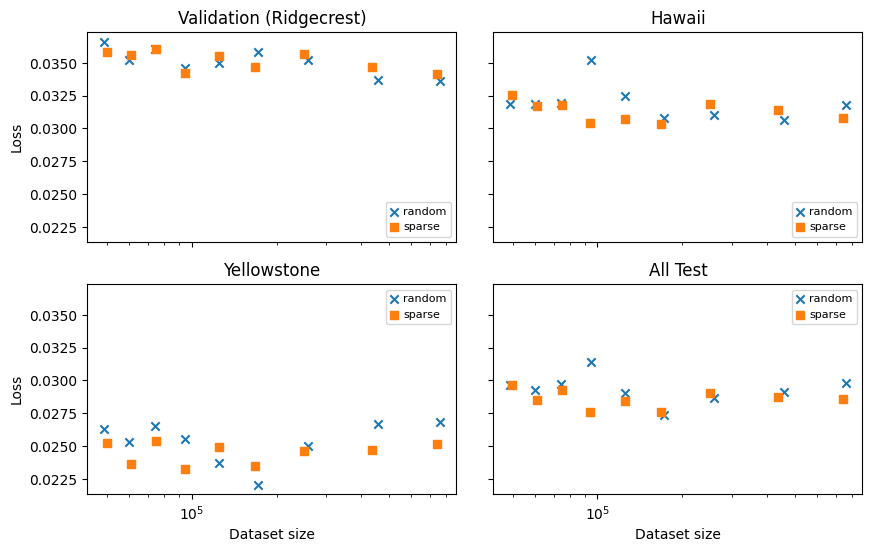

In [49]:
fig,axs = plt.subplots(2,2, figsize=(10,6),sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
axs = axs.flatten()

df1 = df_rnd_exp3
df2 = df_spr_exp3

axs[0].scatter(df1["data size"],df1["val_loss"],marker="x",label="random")
axs[0].scatter(df2["data size"],df2["val_loss"],marker="s",label="sparse")

axs[1].scatter(df1["data size"],df1["haw_loss"],marker="x",label="random")
axs[1].scatter(df2["data size"],df2["haw_loss"],marker="s",label="sparse")

axs[2].scatter(df1["data size"],df1["ylw_loss"],marker="x",label="random")
axs[2].scatter(df2["data size"],df2["ylw_loss"],marker="s",label="sparse")

axs[3].scatter(df1["data size"],df1["all_loss"],marker="x",label="random")
axs[3].scatter(df2["data size"],df2["all_loss"],marker="s",label="sparse")

axs[0].set_xscale("log")
axs[0].set_title("Validation (Ridgecrest)"), axs[1].set_title("Hawaii")
axs[2].set_title("Yellowstone"), axs[3].set_title("All Test")
axs[0].set_ylabel("Loss"), axs[2].set_ylabel("Loss")
axs[2].set_xlabel("Dataset size"), axs[3].set_xlabel("Dataset size")
for idx,ax in enumerate(axs):
    loc = "upper right" if idx>=2 else "lower right"
    ax.legend(loc=loc,handlelength=0.63,handletextpad=0.5,fontsize=8)


# plt.savefig(f"{get_repo_dir()}/figures/compare_exp_test_metrics.png",
#             dpi=200,edgecolor="none",bbox_inches="tight")
plt.show()

### Uncertainty plot

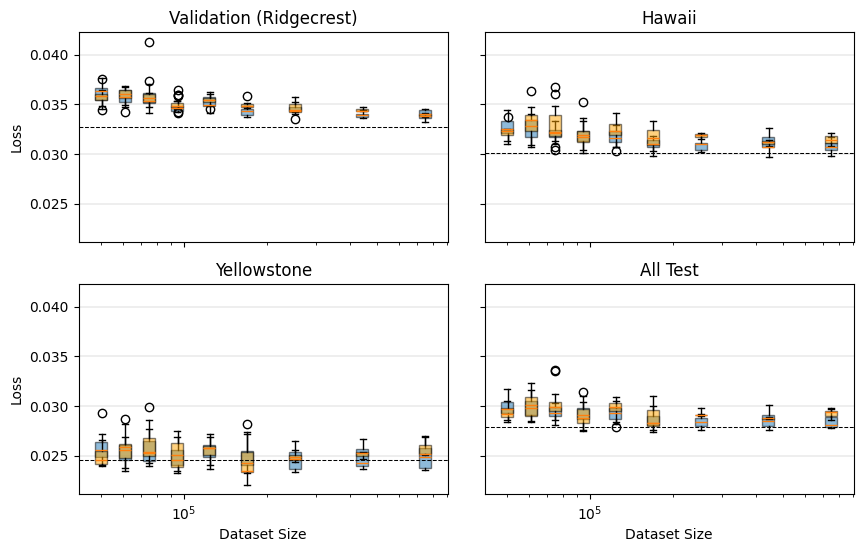

In [78]:
fig,axs = plt.subplots(2,2, figsize=(10,6),sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
axs = axs.flatten()

for idx,metric in enumerate(["val_loss","haw_loss","ylw_loss","all_loss"]):
    group_rand = df_rnd_all.groupby("data size")[metric].apply(list)
    positions = group_rand.index.values  # these are your x-values (data sizes)
    data_rd = group_rand.values          

    # tmp = df_spr_all.copy()
    # tmp[metric] = tmp[metric]  - 0.005
    group_sparse = df_spr_all.groupby("data size")[metric].apply(list)
    positions = group_sparse.index.values  # these are your x-values (data sizes)
    data_sp = group_sparse.values

    bplt_rd = axs[idx].boxplot(data_rd, positions=positions, widths=positions * 0.1, 
                               label="random", patch_artist=True)
    for box in bplt_rd["boxes"]:
        box.set_facecolor("C0")
        box.set_alpha(0.5)

    bplt_sp = axs[idx].boxplot(data_sp, positions=positions, widths=positions * 0.1, 
                               label="sparse", patch_artist=True)
    for box in bplt_sp["boxes"]:
        box.set_facecolor("orange")
        box.set_alpha(0.5)

axs[0].axhline(0.03274, c="k", ls="--", lw=0.75, label="baseline")
axs[1].axhline(0.0300617, c="k", ls="--", lw=0.75, label="baseline")
axs[2].axhline(0.02452684, c="k", ls="--", lw=0.75, label="baseline")
axs[3].axhline(0.02786767, c="k", ls="--", lw=0.75, label="baseline")


axs[0].set_xscale("log")
axs[0].set_title("Validation (Ridgecrest)"), axs[1].set_title("Hawaii")

# plt.xticks(rotation=70)
axs[2].set_title("Yellowstone"), axs[3].set_title("All Test")
axs[0].set_ylabel("Loss"), axs[2].set_ylabel("Loss")
axs[2].set_xlabel("Dataset Size"), axs[3].set_xlabel("Dataset Size")
for idx,ax in enumerate(axs):
    loc = "upper right" if idx>=2 else "lower right"
    # ax.legend(loc=loc,handlelength=0.63,handletextpad=0.5,fontsize=8)
    ax.yaxis.grid(True, lw=0.3)

plt.savefig(f"{get_repo_dir()}/figures/compare_exp_loss_uncertainty.png",
            dpi=200,edgecolor="none",bbox_inches="tight")

plt.show()


### Test Loss

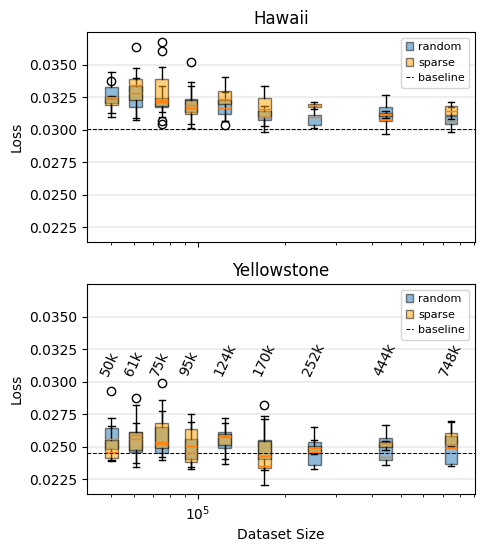

In [113]:
fig,axs = plt.subplots(2,1, figsize=(5,6),sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
axs = axs.flatten()

for idx,metric in enumerate(["haw_loss","ylw_loss"]):
    group_rand = df_rnd_all.groupby("data size")[metric].apply(list)
    positions = group_rand.index.values  # these are your x-values (data sizes)
    data_rd = group_rand.values          

    group_sparse = df_spr_all.groupby("data size")[metric].apply(list)
    positions = group_sparse.index.values  # these are your x-values (data sizes)
    data_sp = group_sparse.values


    bplt_rd = axs[idx].boxplot(data_rd, positions=positions, widths=positions * 0.1, 
                               label="random", patch_artist=True)
    for box in bplt_rd["boxes"]:
        box.set_facecolor("C0")
        box.set_alpha(0.5)

    bplt_sp = axs[idx].boxplot(data_sp, positions=positions, widths=positions * 0.1, 
                               label="sparse", patch_artist=True)
    for box in bplt_sp["boxes"]:
        box.set_facecolor("orange")
        box.set_alpha(0.5)
    
    if idx == 1:
        for pos in positions:
            axs[idx].annotate(f"{pos/1000:.0f}k", xy=(pos,0.0305), xytext=(-10, 0),
                              textcoords="offset points", rotation=65)

axs[0].axhline(0.0300617, c="k", ls="--", lw=0.75, label="baseline")
axs[1].axhline(0.02452684, c="k", ls="--", lw=0.75, label="baseline")


axs[0].set_xscale("log")
axs[0].set_title("Hawaii"), axs[1].set_title("Yellowstone")
axs[0].set_ylabel("Loss"), axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Dataset Size")
for idx,ax in enumerate(axs):
    loc = "upper right" if idx>=0 else "lower right"
    ax.legend(loc=loc,handlelength=0.63,handletextpad=0.5,fontsize=8)
    ax.yaxis.grid(True, lw=0.3)

plt.savefig(f"{get_repo_dir()}/figures/compare_exp_test_loss_uncertainty.png",
            dpi=200,edgecolor="none",bbox_inches="tight")

plt.show()


### Test Recall

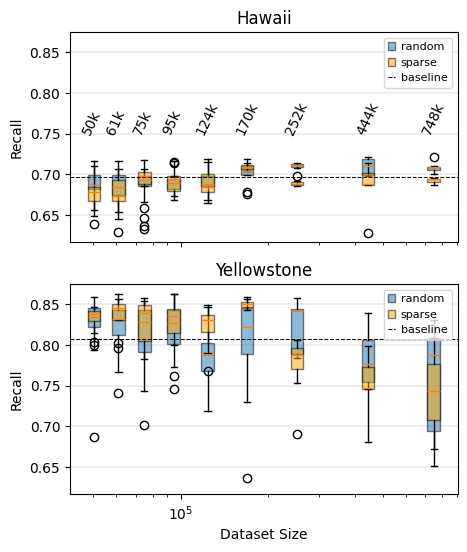

In [142]:
fig,axs = plt.subplots(2,1, figsize=(5,6),sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
axs = axs.flatten()

for idx,metric in enumerate(["haw_rcl","ylw_rcl"]):
    df_rnd = df_rnd_all.copy()
    df_rnd = df_rnd[(df_rnd.haw_rcl>0.2) | (df_rnd.ylw_rcl>0.2)]
    group_rand = df_rnd.groupby("data size")[metric].apply(list)
    positions = group_rand.index.values  # these are your x-values (data sizes)
    data_rd = group_rand.values

    df_spr = df_spr_all.copy()
    df_spr = df_spr[(df_spr.haw_rcl>0.2) | (df_spr.ylw_rcl>0.2)]
    group_sparse = df_spr.groupby("data size")[metric].apply(list)
    positions = group_sparse.index.values  # these are your x-values (data sizes)
    data_sp = group_sparse.values


    bplt_rd = axs[idx].boxplot(data_rd, positions=positions, widths=positions * 0.1, 
                               label="random", patch_artist=True)
    for box in bplt_rd["boxes"]:
        box.set_facecolor("C0")
        box.set_alpha(0.5)

    bplt_sp = axs[idx].boxplot(data_sp, positions=positions, widths=positions * 0.1, 
                               label="sparse", patch_artist=True)
    for box in bplt_sp["boxes"]:
        box.set_facecolor("orange")
        box.set_alpha(0.5)
    
    if idx == 0:
        for pos in positions:
            axs[idx].annotate(f"{pos/1000:.0f}k", xy=(pos,0.75), xytext=(-10, 0),
                              textcoords="offset points", rotation=65)

axs[0].axhline(0.697, c="k", ls="--", lw=0.75, label="baseline")
axs[1].axhline(0.807, c="k", ls="--", lw=0.75, label="baseline")


axs[0].set_xscale("log")
axs[0].set_title("Hawaii"), axs[1].set_title("Yellowstone")
axs[0].set_ylabel("Recall"), axs[1].set_ylabel("Recall")
axs[1].set_xlabel("Dataset Size")
for idx,ax in enumerate(axs):
    loc = "upper right" if idx>=0 else "lower right"
    ax.legend(loc=loc,handlelength=0.63,handletextpad=0.5,fontsize=8)
    ax.yaxis.grid(True, lw=0.3)

plt.savefig(f"{get_repo_dir()}/figures/compare_exp_test_recall_uncertainty.png",
            dpi=200,edgecolor="none",bbox_inches="tight")

plt.show()


### Test F1-Score

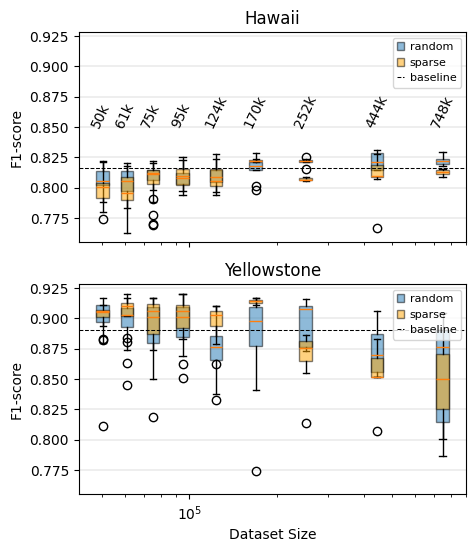

In [145]:
fig,axs = plt.subplots(2,1, figsize=(5,6),sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
axs = axs.flatten()

for idx,metric in enumerate(["haw_f1","ylw_f1"]):
    df_rnd = df_rnd_all.copy()
    df_rnd = df_rnd[(df_rnd.haw_f1>0.4) | (df_rnd.ylw_f1>0.4)]
    group_rand = df_rnd.groupby("data size")[metric].apply(list)
    positions = group_rand.index.values  # these are your x-values (data sizes)
    data_rd = group_rand.values

    df_spr = df_spr_all.copy()
    df_spr = df_spr[(df_spr.haw_f1>0.4) | (df_spr.ylw_f1>0.4)]
    group_sparse = df_spr.groupby("data size")[metric].apply(list)
    positions = group_sparse.index.values  # these are your x-values (data sizes)
    data_sp = group_sparse.values


    bplt_rd = axs[idx].boxplot(data_rd, positions=positions, widths=positions * 0.1, 
                               label="random", patch_artist=True)
    for box in bplt_rd["boxes"]:
        box.set_facecolor("C0")
        box.set_alpha(0.5)

    bplt_sp = axs[idx].boxplot(data_sp, positions=positions, widths=positions * 0.1, 
                               label="sparse", patch_artist=True)
    for box in bplt_sp["boxes"]:
        box.set_facecolor("orange")
        box.set_alpha(0.5)
    
    if idx == 0:
        for pos in positions:
            axs[idx].annotate(f"{pos/1000:.0f}k", xy=(pos,0.85), xytext=(-10, 0),
                              textcoords="offset points", rotation=65)

axs[0].axhline(0.816, c="k", ls="--", lw=0.75, label="baseline")
axs[1].axhline(0.890, c="k", ls="--", lw=0.75, label="baseline")


axs[0].set_xscale("log")
axs[0].set_title("Hawaii"), axs[1].set_title("Yellowstone")
axs[0].set_ylabel("F1-score"), axs[1].set_ylabel("F1-score")
axs[1].set_xlabel("Dataset Size")
for idx,ax in enumerate(axs):
    loc = "upper right" if idx>=0 else "lower right"
    ax.legend(loc=loc,handlelength=0.63,handletextpad=0.5,fontsize=8)
    ax.yaxis.grid(True, lw=0.3)

plt.savefig(f"{get_repo_dir()}/figures/compare_exp_test_f1score_uncertainty.png",
            dpi=200,edgecolor="none",bbox_inches="tight")

plt.show()


### Error Bars

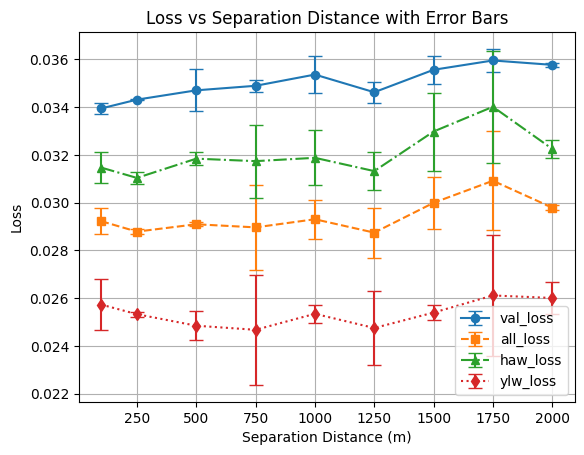

In [91]:
# Assuming your DataFrame is called `df`
grouped = df2.groupby("dist_m").agg({
    "val_loss": ["mean", "std"],
    "all_loss": ["mean", "std"],
    "haw_loss": ["mean", "std"],
    "ylw_loss": ["mean", "std"]
})

# Flatten multi-index columns
grouped.columns = ["_".join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

plt.errorbar(grouped["dist_m"], grouped["val_loss_mean"], yerr=grouped["val_loss_std"],
             fmt='o-', label='val_loss', capsize=5)
plt.errorbar(grouped["dist_m"], grouped["all_loss_mean"], yerr=grouped["all_loss_std"],
             fmt='s--', label='all_loss', capsize=5)
plt.errorbar(grouped["dist_m"], grouped["haw_loss_mean"], yerr=grouped["haw_loss_std"],
             fmt='^-.', label='haw_loss', capsize=5)
plt.errorbar(grouped["dist_m"], grouped["ylw_loss_mean"], yerr=grouped["ylw_loss_std"],
             fmt='d:', label='ylw_loss', capsize=5)

plt.xlabel("Separation Distance (m)")
plt.ylabel("Loss")
plt.title("Loss vs Separation Distance with Error Bars")
plt.legend()
plt.grid(True)
plt.show()


```python
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
```

In [ ]:
# rsync -a ./project/mlruns/518695555362684781/e449191f76614975b7a1bf4fb060abd3/* jomojola@darwin-fe1.lanl.gov:/home/jomojola/project/mlruns/518695555362684781/e449191f76614975b7a1bf4fb060abd3

# rsync -a ./project/* jomojola@darwin-fe1.lanl.gov:/home/jomojola/project